In [52]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import Ridge, Lasso, ElasticNet , LinearRegression
from  sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder ,MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel

In [3]:
url = 'https://myrealty.am/hy/bnakaranneri-vacharq/Yerevan/7762?page='
data = []
for i in range(1,3):
    url_page = url + str(i)
    response = requests.get(url_page)
    response.text
    soup = BeautifulSoup(response.text, 'html.parser')


    for i in soup.find_all('div', class_='item-more mt-auto show-on-list d-flex'):
        link = i.a['href']
        house_response = requests.get(link)
        house_soup = BeautifulSoup(house_response.text, 'html.parser')

        house_id = house_soup.find('div',class_ = 'item-view-id').text.strip().split('ID ')[1]
        add_text = house_soup.find('div',class_ = 'col-auto item-view-address pl-0 mb-2 mt-1').text.strip().split(',')
        town ,distrinct, street = add_text[0] , add_text[1], add_text[2]
        price = house_soup.find('div',class_ = 'item-view-price').text.split()[0].strip()

        params_div = house_soup.find_all('ul', class_='item-view-list-params')
        house_div =  house_soup.find_all('div',class_ = 'col-12 d-flex justify-content-between justify-content-sm-start item-view-price-params')

        house_params0 = {}

        for param in params_div:
            params_items = param.find_all('li')  
            
            for item in params_items:
                label = item.find('label')  
                span = item.find('span')  
                
                label_text = label.text.strip() if label else "No label"
                span_text = span.text.strip() if span else "No value"
                house_params0[label_text] = span_text

            
        house_params1 = {}
        for house in house_soup.find_all("div", class_="col-12 d-flex justify-content-between justify-content-sm-start item-view-price-params"):
            for item in house.find_all("div"):
                label = item.find("label").text.strip()
                value = item.find("span").text.strip()
                house_params1[label] = value  
        

        house_data = {
            'ID' : house_id,
            'town' : town,
            'districts' : distrinct,
            'street' : street,
            'Գին' : price
        }

        house_data.update(house_params0)
        house_data.update(house_params1)

        data.append(house_data)

df= pd.DataFrame(data)

In [173]:
!pip freeze > requirements.txt

In [23]:
os.getcwd()
os.listdir()

['real_estate.ipynb', 'real_estate.csv']

In [86]:
df= pd.read_csv('real_estate.csv',encoding='utf-8')


In [30]:
df.shape

(2759, 14)

In [87]:
xTrain, xTest, yTrain, yTest = train_test_split(df[df.columns.difference(['Գին'])],df['Գին'], test_size=0.2, random_state=10)

In [130]:
def preprocessing(df):
    df = df.rename(columns={"Առաստաղի բարձրություն": "Height", "Գին (Ք.Մ.)": "Price_sq", "Հարկ/Հարկանի":'Floor'
                        , "Մակերես":"Square", "Շինության տիպը" : "Building_type","Սանհանգույց" :"Num_toil",
                        "Սենյակ":"Num_room","Վիճակը":"Condition", "Գին" : "Price"})
    df['Height'] = df['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
    df = df.drop(df[df.Price_sq == 'Պայմ.'].index)
    df['Price_sq'] = df['Price_sq'].str.replace(',','').astype(float)
    df['Square'] = df['Square'].str.replace(' Ք.Մ.','').astype(float)
    df['Num_toil'] = df['Num_toil'].str.replace('+','').astype(float)
    df['Num_room'] = df['Num_room'].str.replace('+','').astype(float)
    df['Price'] = df['Price'].str.replace(',','').astype(float)
    df['Floor'] = df['Floor'].apply(lambda x: eval(x))
    df.drop(['ID','street', 'town','Unnamed: 0'],axis = 1,inplace= True)
    return  df

def split(df):
    xTrain, xTest, yTrain, yTest = train_test_split(df[df.columns.difference(['Գին'])],df['Գին'], test_size=0.2, random_state=10)
    return xTrain , xTest, yTrain, yTest

def encoding(xTrain):
    numeric_cols = xTrain.select_dtypes(include=['number']).columns
    categorical_cols = xTrain.select_dtypes(exclude=['number']).columns

    encoder = OneHotEncoder()
    encoded_fit = encoder.fit(xTrain[categorical_cols])
    encoded_trans=encoded_fit.transform(xTrain[categorical_cols])
    encoder_df = pd.DataFrame(encoded_trans, columns=encoder.get_feature_names_out(categorical_cols), index=xTrain.index)
    xTrain_numeric = xTrain[numeric_cols]
    xTrain_endc = pd.concat([xTrain_numeric, encoder_df], axis=1)
    return xTrain_endc

def scaling(xTrain):
    numeric_cols = xTrain.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    scaler.fit(xTrain[numeric_cols])
    xTrain_scaled = scaler.transform(xTrain[numeric_cols])
    xTrain_scaled= pd.DataFrame(xTrain_scaled, columns=numeric_cols, index=xTrain.index)
    return xTrain_scaled




In [ ]:
xTrain['Height'] = xTrain['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
xTrain['Price_sq'] = xTrain['Price_sq'].str.replace(',','').str.replace('Պայմ.','').replace('',np.nan).astype(float)
xTrain['Square'] = xTrain['Square'].str.replace(' Ք.Մ.','').astype(float)
xTrain['Num_toil'] = xTrain['Num_toil'].str.replace('+','').astype(float)
xTrain['Num_room'] = xTrain['Num_room'].str.replace('+','').astype(float)
xTrain['Floor'] = xTrain['Floor'].apply(lambda x: eval(x))
xTrain.drop(['ID','street', 'town','Unnamed: 0'],axis = 1,inplace= True)
numeric_cols = xTrain.select_dtypes(include=['number']).columns
categorical_cols = xTrain.select_dtypes(exclude=['number']).columns
encoder = OneHotEncoder(sparse_output=False)
encoded_array = encoder.fit_transform(xTrain[categorical_cols])
encoder_df = pd.DataFrame(encoded_array,columns=encoder.get_feature_names_out(categorical_cols))
xTrain_comb= pd.concat([xTrain[numeric_cols], encoder_df], axis=1)

In [98]:
encoder = OneHotEncoder(sparse_output=False)  
encoded_array = encoder.fit_transform(xTrain[categorical_cols])
encoder_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols), index=xTrain.index)
xTrain_numeric = xTrain[numeric_cols]
xTrain_final = pd.concat([xTrain_numeric, encoder_df], axis=1)
xTrain_final.head()

,Height,Price_sq,Floor,Square,Num_toil,Num_room,districts_ Աջափնյակ,districts_ Ավան,districts_ Արաբկիր,districts_ Դավթաշեն,...,districts_ Նորք Մարաշ,districts_ Շենգավիթ,districts_ Քանաքեռ-Զեյթուն,Building_type_Այլ,Building_type_Մոնոլիտ,Building_type_Պանելային,Building_type_Քարե,Condition_Զրոյական,Condition_Լավ,Condition_Վերանորոգված
2098,3.2,3302.0,0.937500,106.0,2.0,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1098,3.0,2283.0,0.428571,127.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
801,3.0,4771.0,0.411765,131.0,2.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2049,3.0,4000.0,0.733333,50.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2246,3.2,6413.0,0.600000,92.0,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [99]:
scaler = MinMaxScaler()
scaler.fit(xTrain_final)
xTrain_scaled = scaler.transform(xTrain_final)
xTrain_f = pd.DataFrame(xTrain_scaled, columns=xTrain_final.columns, index=xTrain_final.index)

In [93]:
xTrain[numeric_cols].corr().style.background_gradient()

,Unnamed: 0,Height,Price_sq,Floor,Square,Num_toil,Num_room
Unnamed: 0,1.000000,0.058446,0.037335,-0.000883,0.003463,-0.009870,-0.001549
Height,0.058446,1.000000,0.092123,0.038934,0.114049,0.173607,0.091991
Price_sq,0.037335,0.092123,1.000000,-0.033127,-0.011898,0.109046,0.026502
Floor,-0.000883,0.038934,-0.033127,1.000000,0.083751,0.050962,0.073568
Square,0.003463,0.114049,-0.011898,0.083751,1.000000,0.479635,0.505263
Num_toil,-0.009870,0.173607,0.109046,0.050962,0.479635,1.000000,0.619315
Num_room,-0.001549,0.091991,0.026502,0.073568,0.505263,0.619315,1.000000


# Lasso

In [103]:
xTrain_f.drop(['Unnamed: 0'],axis =1,inplace = True)

KeyError: "['Unnamed: 0'] not found in axis"

In [104]:
xTrain_fill = xTrain_f.dropna()
yTrain_fill = yTrain.loc[xTrain_fill.index]

In [116]:
lasso=Lasso(random_state=99)
params={'alpha':[1e-5,1e-4,1e-3,1e-2,0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10,20,30,40,50,100, 200, 300, 400,500]}
Regressor=GridSearchCV(lasso,params,scoring='neg_mean_squared_error',cv=10)
Regressor.fit(xTrain_fill, yTrain_fill)
print('best parameter: ', Regressor.best_params_)
print('best score: ', -Regressor.best_score_)

/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e+13, tolerance: 1.135e+10
  model = cd_fast.enet_coordinate_descent(
/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+13, tolerance: 1.128e+10
  model = cd_fast.enet_coordinate_descent(
/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

best parameter:  {'alpha': 500}
best score:  41915371042.35936


In [106]:
feature_sel_model = SelectFromModel(Lasso(alpha=500, random_state=99)) 
feature_sel_model.fit(xTrain_fill, yTrain_fill)

SelectFromModel(estimator=Lasso(alpha=500, random_state=99))

In [107]:
selected_feat = xTrain_fill.columns[(feature_sel_model.get_support())]
print('total features: {}'.format((xTrain_fill.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_sel_model.estimator_.coef_ == 0)))

total features: 24
selected features: 16
features with coefficients shrank to zero: 8


In [108]:
xTrain_selected = xTrain_fill[selected_feat]


# Ridge

In [110]:
r = Ridge()
alpha = np.linspace(0,1)
gs_r = GridSearchCV(r, {'alpha': alpha})
gs_r.fit(xTrain_selected, yTrain_fill)
cross_val_score(gs_r.best_estimator_, xTrain_selected ,yTrain_fill).mean()
final_cls = gs_r.best_estimator_
final_cls.fit(xTrain_selected, yTrain_fill)
print(final_cls.score(xTrain_selected, yTrain_fill))
final_cls
# y_predK= final_cls.predict(xTest)

/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.87631e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.17957e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


0.5770391504803135


Ridge(alpha=np.float64(1.0))

# KNN

In [111]:
knn = KNeighborsRegressor(n_neighbors=5)
cross_val_score(knn, xTrain_selected, yTrain_fill).mean()
gs = GridSearchCV(knn, {'n_neighbors': range(2, 30), 'weights':['uniform','distance']})
gs.fit(xTrain_selected, yTrain_fill)
print(gs.best_estimator_)
[cross_val_score(gs.best_estimator_, xTrain_selected, yTrain_fill).mean(),cross_val_score(knn, xTrain_selected, yTrain_fill).mean()]

KNeighborsRegressor(n_neighbors=12, weights='distance')


[np.float64(0.6697628136506534), np.float64(0.5678685012486728)]

# Elastic Net

In [112]:
l1_ratio = np.linspace(0,1)
elastic = ElasticNet(l1_ratio= l1_ratio)
params={'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,10,20,30,40,50,100,],'l1_ratio':l1_ratio}
Regressor=GridSearchCV(elastic,params,scoring='neg_mean_squared_error',cv=10)
Regressor.fit(xTrain_selected, yTrain_fill)
#Print best parameter and score
print('best parameter: ', Regressor.best_params_)
print('best score: ', -Regressor.best_score_)

/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.360e+13, tolerance: 1.135e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.357e+13, tolerance: 1.128e+10 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one

best parameter:  {'alpha': 0.001, 'l1_ratio': np.float64(0.16326530612244897)}
best score:  26204060929.98387


/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.655e+12, tolerance: 1.266e+10
  model = cd_fast.enet_coordinate_descent(


In [113]:
elNet = ElasticNet(alpha = list(Regressor.best_params_.values())[0],l1_ratio = list(Regressor.best_params_.values())[1])
elNet.fit(xTrain_selected, yTrain_fill)
# y_predE = elNet.predict(xTest)
train_score = elNet.score(xTrain_selected, yTrain_fill)
# test_score = elNet.score(xTest, yTest)
train_score


/Users/AlisaDavtyan2/Desktop/.conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.655e+12, tolerance: 1.266e+10
  model = cd_fast.enet_coordinate_descent(


0.5633725646157955

# Linear regression

In [115]:
regr = LinearRegression()
regr.fit(xTrain_selected,yTrain_fill)
y_pred = regr.predict(xTrain_selected)
train_score = regr.score(xTrain_selected, y_pred)
train_score

1.0

In [161]:
df.head()

,Unnamed: 0,ID,town,districts,street,Գին,Գին (Ք.Մ.),Սանհանգույց,Շինության տիպը,Առաստաղի բարձրություն,Վիճակը,Մակերես,Սենյակ,Հարկ/Հարկանի
0,0,154013,Երևան,Կենտրոն,Խորենացու փող,"112,000","2,333",1,Պանելային,2.8 Մ,Լավ,48 Ք.Մ.,2,3/9
1,1,154286,Երևան,Արաբկիր,Մալխասյանց փող,"166,000","2,156",1,Մոնոլիտ,3.2 Մ,Զրոյական,77 Ք.Մ.,2,12/14
2,2,154285,Երևան,Կենտրոն,Ռոստոմի փող,"245,000","3,182",1,Մոնոլիտ,3 Մ,Վերանորոգված,77 Ք.Մ.,3,8/15
3,3,154289,Երևան,Արաբկիր,Վ.Փափազյան փող,"130,000","2,500",1,Քարե,2.8 Մ,Վերանորոգված,52 Ք.Մ.,3,4/5
4,4,154598,Երևան,Կենտրոն,Տիգրան Մեծի պող,"255,000","3,110",2,Քարե,3 Մ,Վերանորոգված,82 Ք.Մ.,4,2/5


In [166]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

class PricePredictionPipeline:
    def __init__(self):
        self.numeric_features = None
        self.categorical_features = None
        self.preprocessor = None
        self.models = {}
        self.best_model = None
        
    def preprocess_data(self, df):
        """Clean and preprocess the initial dataframe"""
        df = df.rename(columns={
            "Առաստաղի բարձրություն": "Height",
            "Գին (Ք.Մ.)": "Price_sq",
            "Հարկ/Հարկանի": 'Floor',
            "Մակերես": "Square",
            "Շինության տիպը": "Building_type",
            "Սանհանգույց": "Num_toil",
            "Սենյակ": "Num_room",
            "Վիճակը": "Condition",
            "Գին": "Price"
        })
        
        # Clean numeric columns
        df = df.drop(df[df.Price_sq == 'Պայմ.'].index)
        df['Height'] = df['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
        df['Price_sq'] = df['Price_sq'].str.replace(',','').astype(float)
        df['Square'] = df['Square'].str.replace(' Ք.Մ.','').astype(float)
        df['Num_toil'] = df['Num_toil'].str.replace('+','').astype(float)
        df['Num_room'] = df['Num_room'].str.replace('+','').astype(float)
        df['Price'] = df['Price'].str.replace(',', '', regex=True)
        df['Floor'] = df['Floor'].apply(lambda x: eval(x))
        df['Price'] = df['Price'].astype(str).str.replace(',','').astype(float)

        # Drop unnecessary columns
        df.drop(['ID', 'street', 'town', 'Unnamed: 0','districts'], axis=1, inplace=True)
        
        return df
        
    def create_preprocessing_pipeline(self, X):
        """Create preprocessing pipeline with proper column handling"""
        self.numeric_features = X.select_dtypes(include=['number']).columns
        self.categorical_features = X.select_dtypes(exclude=['number']).columns
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ])
        
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False))
        ])
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.numeric_features),
                ('cat', categorical_transformer, self.categorical_features)
            ])
        
        return self.preprocessor
    
    def train_models(self, X_train, y_train):
        """Train multiple models with grid search"""
        # Define models and their parameter grids
        model_params = {
            'lasso': {
                'model': Lasso(random_state=99),
                'params': {
                    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
                }
            },
            'ridge': {
                'model': Ridge(random_state=99),
                'params': {
                    'alpha': np.linspace(0, 1, 10)
                }
            },
            'knn': {
                'model': KNeighborsRegressor(),
                'params': {
                    'n_neighbors': range(2, 30),
                    'weights': ['uniform', 'distance']
                }
            },

            'linear': {
                'model': LinearRegression(),
                'params': {
                }
            },


        }
        
        # Train each model with grid search
        for name, config in model_params.items():
            pipeline = Pipeline([
                ('preprocessor', self.preprocessor),
                ('regressor', config['model'])
            ])
            
            grid_search = GridSearchCV(
                pipeline,
                {f'regressor__{k}': v for k, v in config['params'].items()},
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1
            )
            
            grid_search.fit(X_train, y_train)
            self.models[name] = grid_search
            
            print(f"\n{name.upper()} Results:")
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best CV score: {-grid_search.best_score_:.2f} MSE")
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all models and print metrics"""
        results = {}
        
        for name, model in self.models.items():
            y_pred = model.predict(X_test)
            
            metrics = {
                'R2': r2_score(y_test, y_pred),
                'MSE': mean_squared_error(y_test, y_pred),
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'MAE': mean_absolute_error(y_test, y_pred)
            }
            
            results[name] = metrics
            
            print(f"\n{name.upper()} Metrics:")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.2f}")
        
        # Find best model based on RMSE
        best_model_name = min(results, key=lambda x: results[x]['RMSE'])
        self.best_model = self.models[best_model_name]
        print(f"\nBest performing model: {best_model_name}")
        
        return results

# Usage example
if __name__ == "__main__":
    # Load data
    df = pd.read_csv('real_estate.csv', encoding='utf-8')
    
    # Initialize pipeline
    pipeline = PricePredictionPipeline()
    
    # Preprocess data
    df_cleaned = pipeline.preprocess_data(df)
    
    # Split data
    X = df_cleaned.drop('Price', axis=1)
    y = df_cleaned['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    # Create and fit preprocessing pipeline
    preprocessor = pipeline.create_preprocessing_pipeline(X_train)
    
    # Train models
    pipeline.train_models(X_train, y_train)
    
    # Evaluate models
    results = pipeline.evaluate_models(X_test, y_test)


LASSO Results:
Best parameters: {'regressor__alpha': 100}
Best CV score: 106251702730.63 MSE

RIDGE Results:
Best parameters: {'regressor__alpha': np.float64(1.0)}
Best CV score: 95486410941.94 MSE

KNN Results:
Best parameters: {'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}
Best CV score: 17938503886.80 MSE

LINEAR Results:
Best parameters: {}
Best CV score: 108358557692.89 MSE

LASSO Metrics:
R2: 0.61
MSE: 24664589281.96
RMSE: 157049.64
MAE: 80598.08

RIDGE Metrics:
R2: 0.55
MSE: 28302470114.71
RMSE: 168233.38
MAE: 90073.36

KNN Metrics:
R2: 0.45
MSE: 34319256167.46
RMSE: 185254.57
MAE: 69002.47

LINEAR Metrics:
R2: 0.62
MSE: 24054009746.49
RMSE: 155093.55
MAE: 79146.96

Best performing model: linear


In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Preprocess data
def preprocess_data(df):
    df = df.rename(columns={
        "Առաստաղի բարձրություն": "Height",
        "Գին (Ք.Մ.)": "Price_sq",
        "Հարկ/Հարկանի": 'Floor',
        "Մակերես": "Square",
        "Շինության տիպը": "Building_type",
        "Սանհանգույց": "Num_toil",
        "Սենյակ": "Num_room",
        "Վիճակը": "Condition",
        "Գին": "Price"
    })
    
    # Clean numeric columns
    df = df.drop(df[df.Price_sq == 'Պայմ.'].index)
    df['Height'] = df['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
    df['Price_sq'] = df['Price_sq'].str.replace(',','').astype(float)
    df['Square'] = df['Square'].str.replace(' Ք.Մ.','').astype(float)
    df['Num_toil'] = df['Num_toil'] .str.replace('+','').astype(float)
    df['Num_room'] = df['Num_room'].str.replace('+','').astype(float)
    df['Price'] = df['Price'].str.replace(',', '', regex=True)
    df['Floor'] = df['Floor'].apply(lambda x: eval(x))
    df['Price'] = df['Price'].astype(str).str.replace(',','').astype(float)
    
    # Drop unnecessary columns
    df.drop(['ID', 'street', 'town', 'Unnamed: 0','districts','Building_type'], axis=1, inplace=True)
    return df

# Load and preprocess data
df = pd.read_csv('real_estate.csv', encoding='utf-8')
df_cleaned = preprocess_data(df)

# Split data
X = df_cleaned.drop('Price', axis=1)
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Create preprocessing pipeline
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(exclude=['number']).columns

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
print(categorical_features)
# Fit preprocessor and transform data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after preprocessing
feature_names = (numeric_features.tolist() + 
                preprocessor.named_transformers_['cat']
                .named_steps['onehot'].get_feature_names_out(categorical_features).tolist())

# Feature selection with Lasso
lasso = Lasso(random_state=99)
lasso_params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_transformed, y_train)

print("Best Lasso alpha:", lasso_grid.best_params_['alpha'])
print("Lasso CV Score:", -lasso_grid.best_score_)

# Get selected features
lasso_coef = pd.DataFrame(lasso_grid.best_estimator_.coef_, index=feature_names, columns=['Coefficient'])
selected_features = lasso_coef[abs(lasso_coef['Coefficient']) > 0].index.tolist()
print("\nSelected features:", len(selected_features))
print(selected_features)

# Filter data to include only selected features
X_train_selected = X_train_transformed[:, [feature_names.index(feat) for feat in selected_features]]
X_test_selected = X_test_transformed[:, [feature_names.index(feat) for feat in selected_features]]

# Train and evaluate different models using selected features
models = {
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'KNN': KNeighborsRegressor(),
    'Linear': LinearRegression()
}

for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, 
                              scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    # Train model and make predictions
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name} Results:")
    print(f"Cross-validation RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})")
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {np.sqrt(mse):.2f}")
    print(f"R2 Score: {r2:.4f}")

Index(['Condition'], dtype='object')
Best Lasso alpha: 100
Lasso CV Score: 109099016356.0029

Selected features: 8
['Price_sq', 'Num_toil', 'Height', 'Square', 'Num_room', 'Floor', 'Condition_Լավ', 'Condition_Վերանորոգված']

Ridge Results:
Cross-validation RMSE: 282979.02 (+/- 340292.95)
Test MSE: 23595214569.48
Test RMSE: 153607.34
R2 Score: 0.6235

ElasticNet Results:
Cross-validation RMSE: 181018.45 (+/- 65494.95)
Test MSE: 28726107870.83
Test RMSE: 169487.78
R2 Score: 0.5416

KNN Results:
Cross-validation RMSE: 91699.16 (+/- 30324.51)
Test MSE: 11830223113.30
Test RMSE: 108766.83
R2 Score: 0.8112

Linear Results:
Cross-validation RMSE: 283503.87 (+/- 341534.99)
Test MSE: 23590247316.20
Test RMSE: 153591.17
R2 Score: 0.6235


In [138]:
df = pd.read_csv('real_estate.csv', encoding='utf-8')

In [143]:
import matplotlib.pyplot as plt
# df.drop(df[df['Գին'] == 'Պայմ.'])
df = df.drop(df[df.Գին == 'Պայմ.'].index)

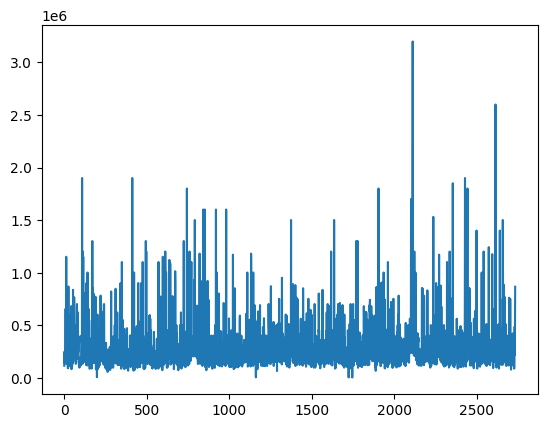

In [151]:
plt.plot(df.index, df['Գին'].str.replace(',','').astype(float))

In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load and preprocess data
def preprocess_data(df):
    df = df.rename(columns={
        "Առաստաղի բարձրություն": "Height",
        "Գին (Ք.Մ.)": "Price_sq",
        "Հարկ/Հարկանի": 'Floor',
        "Մակերես": "Square",
        "Շինության տիպը": "Building_type",
        "Սանհանգույց": "Num_toil",
        "Սենյակ": "Num_room",
        "Վիճակը": "Condition",
        "Գին": "Price"
    })
    
    # Clean numeric columns
    df = df.drop(df[df.Price_sq == 'Պայմ.'].index)
    df['Height'] = df['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
    df['Price_sq'] = df['Price_sq'].str.replace(',','').astype(float)
    df['Square'] = df['Square'].str.replace(' Ք.Մ.','').astype(float)
    df['Num_toil'] = df['Num_toil'].str.replace('+','').astype(float)
    df['Num_room'] = df['Num_room'].str.replace('+','').astype(float)
    df['Price'] = df['Price'].str.replace(',', '', regex=True).astype(float)
    df['Floor'] = df['Floor'].apply(lambda x: eval(x))
    
    # Drop unnecessary columns
    df.drop(['ID', 'street', 'town', 'Unnamed: 0'], axis=1, inplace=True)
    return df

df = pd.read_csv('real_estate.csv', encoding='utf-8')
df_cleaned = preprocess_data(df)

# Remove outliers based on Price
df_cleaned = df_cleaned[df_cleaned['Price'] < df_cleaned['Price'].quantile(0.99)]




# Split data
X = df_cleaned.drop('Price', axis=1)
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Preprocessing pipelines
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(exclude=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names
feature_names = (numeric_features.tolist() + 
                preprocessor.named_transformers_['cat']
                .named_steps['onehot'].get_feature_names_out(categorical_features).tolist())

# Feature selection using Lasso with Cross-Validation

lasso = Lasso(alpha=0.5, random_state=99)
lasso.fit(X_train_transformed, y_train)
lasso_coef = pd.DataFrame(lasso.coef_, index=feature_names, columns=['Coefficient'])
selected_features = lasso_coef[abs(lasso_coef['Coefficient']) > 0].index.tolist()

# Filter dataset based on selected features
X_train_selected = X_train_transformed[:, [feature_names.index(feat) for feat in selected_features]]
X_test_selected = X_test_transformed[:, [feature_names.index(feat) for feat in selected_features]]

# Model evaluation using cross-validation
models = {
    'Ridge': Ridge(alpha=1),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear': LinearRegression()
}

for name, model in models.items():
    # Cross-validation RMSE
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    # Train model and evaluate on test set
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name} Results:")
    print(f"Cross-validation RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})")
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {np.sqrt(mse):.2f}")
    print(f"R2 Score: {r2:.4f}")



Ridge Results:
Cross-validation RMSE: 131586.18 (+/- 133670.77)
Test MSE: 54030256354.45
Test RMSE: 232444.09
R2 Score: -0.6827

ElasticNet Results:
Cross-validation RMSE: 131076.96 (+/- 131722.16)
Test MSE: 53480503161.33
Test RMSE: 231258.52
R2 Score: -0.6656

KNN Results:
Cross-validation RMSE: 71594.39 (+/- 2426.85)
Test MSE: 5918318700.51
Test RMSE: 76930.61
R2 Score: 0.8157

Linear Results:
Cross-validation RMSE: 131662.95 (+/- 133889.21)
Test MSE: 54091227830.23
Test RMSE: 232575.21
R2 Score: -0.6846


In [170]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

def preprocess_data(df):
    df = df.rename(columns={
        "Առաստաղի բարձրություն": "Height",
        "Գին (Ք.Մ.)": "Price_sq",
        "Հարկ/Հարկանի": 'Floor',
        "Մակերես": "Square",
        "Շինության տիպը": "Building_type",
        "Սանհանգույց": "Num_toil",
        "Սենյակ": "Num_room",
        "Վիճակը": "Condition",
        "Գին": "Price"
    })
    
    # Clean numeric columns
    df = df.drop(df[df.Price_sq == 'Պայմ.'].index)
    df['Height'] = df['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
    df['Price_sq'] = df['Price_sq'].str.replace(',','').astype(float)
    df['Square'] = df['Square'].str.replace(' Ք.Մ.','').astype(float)
    df['Num_toil'] = df['Num_toil'].str.replace('+','').astype(float)
    df['Num_room'] = df['Num_room'].str.replace('+','').astype(float)
    df['Price'] = df['Price'].str.replace(',', '', regex=True)
    df['Floor'] = df['Floor'].apply(lambda x: eval(x))
    df['Price'] = df['Price'].astype(str).str.replace(',','').astype(float)
    
    # Drop unnecessary columns
    df.drop(['ID', 'street', 'town', 'Unnamed: 0', 'districts', 'Building_type'], axis=1, inplace=True)
    return df

# Load and preprocess data
df = pd.read_csv('real_estate.csv', encoding='utf-8')
df_cleaned = preprocess_data(df)

# Split data first
X = df_cleaned.drop('Price', axis=1)
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(exclude=['number']).columns

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Changed to median for robustness
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Create feature selection pipeline
feature_selection = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])),
    ('feature_selector', Lasso(alpha=0.01, random_state=42))  # Initial alpha for feature selection
])

# Create model evaluation pipeline
def evaluate_model(model, X_train, X_test, y_train, y_test, preprocessor):
    # Fit preprocessor on training data only
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Perform cross-validation on training data
    cv_scores = cross_val_score(model, X_train_transformed, y_train, 
                              cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    
    # Train model and make predictions
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'cv_rmse_mean': rmse_scores.mean(),
        'cv_rmse_std': rmse_scores.std() * 2,
        'test_mse': mse,
        'test_rmse': np.sqrt(mse),
        'r2_score': r2
    }

# Tune Lasso for feature selection
lasso_params = {'alpha': np.logspace(-5, 2, 20)}
lasso_grid = GridSearchCV(
    feature_selection, 
    {'feature_selector__alpha': lasso_params['alpha']},
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
lasso_grid.fit(X_train, y_train)

print("Best Lasso alpha:", lasso_grid.best_params_['feature_selector__alpha'])
print("Best Lasso CV Score:", np.sqrt(-lasso_grid.best_score_))

# Get selected features
best_preprocessor = lasso_grid.best_estimator_.named_steps['preprocessor']
feature_names = (numeric_features.tolist() + 
                best_preprocessor.named_transformers_['cat']
                .named_steps['onehot'].get_feature_names_out(categorical_features).tolist())

lasso_coef = pd.DataFrame(
    lasso_grid.best_estimator_.named_steps['feature_selector'].coef_,
    index=feature_names,
    columns=['Coefficient']
)
selected_features = lasso_coef[abs(lasso_coef['Coefficient']) > 0].index.tolist()
print("\nNumber of selected features:", len(selected_features))
print("Selected features:", selected_features)

# Define and evaluate models
models = {
    'Ridge': Ridge(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear': LinearRegression()
}

# Create final preprocessor with selected features
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [f for f in numeric_features if f in selected_features]),
        ('cat', categorical_transformer, [f for f in categorical_features if f in selected_features])
    ])

# Evaluate each model
for name, model in models.items():
    print(f"\n{name} Results:")
    results = evaluate_model(model, X_train, X_test, y_train, y_test, final_preprocessor)
    print(f"Cross-validation RMSE: {results['cv_rmse_mean']:.2f} (+/- {results['cv_rmse_std']:.2f})")
    print(f"Test MSE: {results['test_mse']:.2f}")
    print(f"Test RMSE: {results['test_rmse']:.2f}")
    print(f"R2 Score: {results['r2_score']:.4f}")

Best Lasso alpha: 100.0
Best Lasso CV Score: 323869.20047488064

Number of selected features: 8
Selected features: ['Price_sq', 'Num_toil', 'Height', 'Square', 'Num_room', 'Floor', 'Condition_Լավ', 'Condition_Վերանորոգված']

Ridge Results:
Cross-validation RMSE: 178232.85 (+/- 47981.19)
Test MSE: 19694892434.73
Test RMSE: 140338.49
R2 Score: 0.5999

ElasticNet Results:
Cross-validation RMSE: 230773.14 (+/- 39971.13)
Test MSE: 45845841873.14
Test RMSE: 214116.42
R2 Score: 0.0687

KNN Results:
Cross-validation RMSE: 160514.73 (+/- 40351.61)
Test MSE: 17963207301.30
Test RMSE: 134026.89
R2 Score: 0.6351

Linear Results:
Cross-validation RMSE: 273330.37 (+/- 345829.67)
Test MSE: 15511793702.33
Test RMSE: 124546.35
R2 Score: 0.6849


In [171]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import joblib
import os
from datetime import datetime

class RealEstatePricePredictor:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {
            'Ridge': Ridge(random_state=self.random_state),
            'ElasticNet': ElasticNet(random_state=self.random_state),
            'KNN': KNeighborsRegressor(n_neighbors=5),
            'Linear': LinearRegression()
        }
        self.best_model = None
        self.best_model_name = None
        self.best_score = float('inf')
        self.feature_selector = None
        self.preprocessor = None
        self.selected_features = None
        
    def preprocess_data(self, df):
        """Preprocess the input dataframe."""
        df = df.rename(columns={
            "Առաստաղի բարձրություն": "Height",
            "Գին (Ք.Մ.)": "Price_sq",
            "Հարկ/Հարկանի": 'Floor',
            "Մակերես": "Square",
            "Շինության տիպը": "Building_type",
            "Սանհանգույց": "Num_toil",
            "Սենյակ": "Num_room",
            "Վիճակը": "Condition",
            "Գին": "Price"
        })
        
        # Clean numeric columns
        df = df.drop(df[df.Price_sq == 'Պայմ.'].index)
        df['Height'] = df['Height'].str.replace(' Մ','').str.replace('+','').astype(float)
        df['Price_sq'] = df['Price_sq'].str.replace(',','').astype(float)
        df['Square'] = df['Square'].str.replace(' Ք.Մ.','').astype(float)
        df['Num_toil'] = df['Num_toil'].str.replace('+','').astype(float)
        df['Num_room'] = df['Num_room'].str.replace('+','').astype(float)
        df['Price'] = df['Price'].str.replace(',', '', regex=True)
        df['Floor'] = df['Floor'].apply(lambda x: eval(x))
        df['Price'] = df['Price'].astype(str).str.replace(',','').astype(float)
        
        # Drop unnecessary columns
        df.drop(['ID', 'street', 'town', 'Unnamed: 0', 'districts', 'Building_type'], 
                axis=1, inplace=True)
        return df
    
    def setup_pipeline(self, X):
        """Set up the preprocessing and feature selection pipeline."""
        numeric_features = X.select_dtypes(include=['number']).columns
        categorical_features = X.select_dtypes(exclude=['number']).columns
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ])

        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        self.feature_selector = Pipeline([
            ('preprocessor', self.preprocessor),
            ('feature_selector', Lasso(random_state=self.random_state))
        ])
        
    def select_features(self, X_train, y_train):
        """Perform feature selection using Lasso."""
        lasso_params = {'alpha': np.logspace(-5, 2, 20)}
        lasso_grid = GridSearchCV(
            self.feature_selector, 
            {'feature_selector__alpha': lasso_params['alpha']},
            cv=5, 
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        lasso_grid.fit(X_train, y_train)
        
        # Get selected features
        feature_names = (
            X_train.select_dtypes(include=['number']).columns.tolist() +
            lasso_grid.best_estimator_.named_steps['preprocessor']
            .named_transformers_['cat'].named_steps['onehot']
            .get_feature_names_out(X_train.select_dtypes(exclude=['number']).columns).tolist()
        )
        
        lasso_coef = pd.DataFrame(
            lasso_grid.best_estimator_.named_steps['feature_selector'].coef_,
            index=feature_names,
            columns=['Coefficient']
        )
        self.selected_features = lasso_coef[abs(lasso_coef['Coefficient']) > 0].index.tolist()
        
        return lasso_grid.best_params_['feature_selector__alpha'], np.sqrt(-lasso_grid.best_score_)
    
    def evaluate_model(self, model, X_train, X_test, y_train, y_test):
        """Evaluate a single model."""
        # Fit preprocessor on training data only
        X_train_transformed = self.preprocessor.fit_transform(X_train)
        X_test_transformed = self.preprocessor.transform(X_test)
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train_transformed, y_train, 
                                  cv=5, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-cv_scores)
        
        # Train model and make predictions
        model.fit(X_train_transformed, y_train)
        y_pred = model.predict(X_test_transformed)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        return {
            'cv_rmse_mean': rmse_scores.mean(),
            'cv_rmse_std': rmse_scores.std() * 2,
            'test_mse': mse,
            'test_rmse': rmse,
            'r2_score': r2,
            'model': model,
            'preprocessor': self.preprocessor
        }
    
    def fit(self, X, y):
        """Fit the model on the provided data."""
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=self.random_state
        )
        
        # Setup pipeline and select features
        self.setup_pipeline(X_train)
        best_alpha, best_score = self.select_features(X_train, y_train)
        print(f"Best Lasso alpha: {best_alpha}")
        print(f"Feature selection score (RMSE): {best_score}")
        print(f"Selected features: {len(self.selected_features)}")
        print(f"Features: {self.selected_features}")
        
        # Evaluate all models
        results = {}
        for name, model in self.models.items():
            print(f"\nEvaluating {name}...")
            results[name] = self.evaluate_model(model, X_train, X_test, y_train, y_test)
            print(f"Cross-validation RMSE: {results[name]['cv_rmse_mean']:.2f} "
                  f"(+/- {results[name]['cv_rmse_std']:.2f})")
            print(f"Test RMSE: {results[name]['test_rmse']:.2f}")
            print(f"R2 Score: {results[name]['r2_score']:.4f}")
            
            # Update best model if current model is better
            if results[name]['test_rmse'] < self.best_score:
                self.best_score = results[name]['test_rmse']
                self.best_model = results[name]['model']
                self.best_model_name = name
                self.preprocessor = results[name]['preprocessor']
        
        print(f"\nBest model: {self.best_model_name} (RMSE: {self.best_score:.2f})")
        
    def predict(self, X):
        """Make predictions using the best model."""
        if self.best_model is None:
            raise ValueError("Model hasn't been trained yet. Call fit() first.")
        X_transformed = self.preprocessor.transform(X)
        return self.best_model.predict(X_transformed)
    
    def save_model(self, directory='models'):
        """Save the best model and preprocessor."""
        if self.best_model is None:
            raise ValueError("No model to save. Train a model first.")
            
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        # Create timestamp for versioning
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Save model components
        model_path = os.path.join(directory, f'best_model_{timestamp}.joblib')
        preprocessor_path = os.path.join(directory, f'preprocessor_{timestamp}.joblib')
        metadata_path = os.path.join(directory, f'metadata_{timestamp}.joblib')
        
        # Save the model and preprocessor
        joblib.dump(self.best_model, model_path)
        joblib.dump(self.preprocessor, preprocessor_path)
        
        # Save metadata
        metadata = {
            'model_name': self.best_model_name,
            'best_score': self.best_score,
            'selected_features': self.selected_features,
            'random_state': self.random_state
        }
        joblib.dump(metadata, metadata_path)
        
        print(f"Model saved in {directory}")
        return model_path, preprocessor_path, metadata_path
    
    @classmethod
    def load_model(cls, model_path, preprocessor_path, metadata_path):
        """Load a saved model and preprocessor."""
        # Load the model components
        model = joblib.load(model_path)
        preprocessor = joblib.load(preprocessor_path)
        metadata = joblib.load(metadata_path)
        
        # Create a new instance and set its attributes
        instance = cls(random_state=metadata['random_state'])
        instance.best_model = model
        instance.preprocessor = preprocessor
        instance.best_model_name = metadata['model_name']
        instance.best_score = metadata['best_score']
        instance.selected_features = metadata['selected_features']
        
        return instance

# Example usage:
if __name__ == "__main__":
    # Load and prepare data
    df = pd.read_csv('real_estate.csv', encoding='utf-8')
    predictor = RealEstatePricePredictor(random_state=42)
    df_cleaned = predictor.preprocess_data(df)
    
    # Split features and target
    X = df_cleaned.drop('Price', axis=1)
    y = df_cleaned['Price']
    
    # Train models
    predictor.fit(X, y)
    
    # Save the best model
    model_path, preprocessor_path, metadata_path = predictor.save_model()
    
    # Load the model
    loaded_predictor = RealEstatePricePredictor.load_model(
        model_path, preprocessor_path, metadata_path
    )
    
    # Make predictions
    sample_prediction = loaded_predictor.predict(X.head())
    print("\nSample predictions:", sample_prediction)

Best Lasso alpha: 100.0
Feature selection score (RMSE): 323869.20047488064
Selected features: 8
Features: ['Price_sq', 'Num_toil', 'Height', 'Square', 'Num_room', 'Floor', 'Condition_Լավ', 'Condition_Վերանորոգված']

Evaluating Ridge...
Cross-validation RMSE: 176749.57 (+/- 45757.07)
Test RMSE: 140041.37
R2 Score: 0.6016

Evaluating ElasticNet...
Cross-validation RMSE: 229196.82 (+/- 39631.13)
Test RMSE: 212352.95
R2 Score: 0.0840

Evaluating KNN...
Cross-validation RMSE: 167779.53 (+/- 36209.09)
Test RMSE: 142153.55
R2 Score: 0.5895

Evaluating Linear...
Cross-validation RMSE: 274939.15 (+/- 352003.50)
Test RMSE: 124678.31
R2 Score: 0.6842

Best model: Linear (RMSE: 124678.31)
Model saved in models

Sample predictions: [ 98604.73939295 136819.75573308 246016.99836751 182916.32528292
 412451.12644393]
